In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/retail_price.csv') \
    .assign(
        month_year=lambda d: pd.to_datetime(d['month_year']),
        year=lambda d: d['month_year'].dt.year,
        month=lambda d: d['month_year'].dt.month,
        weekend=lambda d: d['weekday'].apply(lambda x: 1 if x >= 5 else 0),
        text=lambda d: d['product_category_name'].apply(lambda s: ' '.join(s.split('_')))
    )
df.shape

(676, 31)

In [2]:
def get_Xy(df):
    Xy = df[['unit_price', 'qty']] \
        .groupby(['unit_price']) \
        .sum() \
        .reset_index() \
        .assign(
            p=lambda d: np.log(d['unit_price']),
            q=lambda d: np.log(d['qty'])
        ) \
        .drop(columns=['unit_price', 'qty'])

    X = Xy[['p']]
    y = Xy['q']
    
    return X, y

In [3]:
from sklearn.linear_model import LinearRegression

def get_model(X, y):
    m = LinearRegression()
    m.fit(X, y)
    return m

X, y = get_Xy(df)
m = get_model(X, y)
m.intercept_, m.coef_

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(5.570332323546131, array([-0.58858824]))

In [4]:
import matplotlib.pyplot as plt

def plot_pred(X, y, m, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3.5))
    
    X.assign(q=y) \
        .set_index(['p']) \
        .assign(q_pred=m.predict(X)) \
        .plot(kind='line', ax=ax)
    
    if ax is None:
        fig.tight_layout()

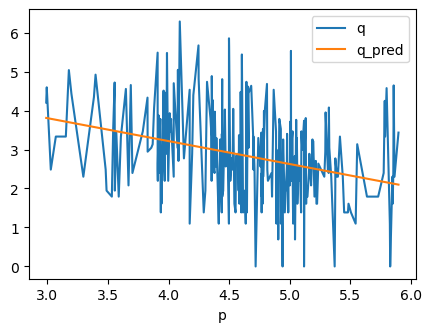

In [5]:
plot_pred(X, y, m)

In [6]:
def get_point_elasticities(X, y, m):
    pnt_df = X.assign(q=y) \
        .assign(
            q=m.predict(X),
            slope=m.coef_[0], 
            ped=lambda d: d['slope'] * d['p'] / d['q']
        )
    return pnt_df

def get_optimal_price(pnt_df):
    s = pnt_df \
        .assign(diff=lambda d: np.abs(d['ped'] + 1)) \
        .sort_values(['diff']) \
        .drop(columns=['diff']) \
        .iloc[0]

    p_opt = np.exp(s.p)
    q_opt = np.exp(s.q)
    e_opt = s.ped

    return pd.Series([
        p_opt,
        q_opt,
        e_opt
    ], index=['price', 'quantity', 'ped'])

In [7]:
pnt_df = get_point_elasticities(X, y, m)
s = get_optimal_price(pnt_df)
s

price       113.333333
quantity     16.217871
ped          -0.999320
dtype: float64

In [8]:
from matplotlib.patches import Ellipse

def plot_point_elasticities(pnt_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3.5))

    pnt_df \
        .assign(p=lambda d: np.exp(d['p'])) \
        .set_index(['p'])['ped'] \
        .plot(kind='line', ylabel=r'$E_p$', title=rf'$E_p$ vs p', ax=ax)

    ax.add_artist(Ellipse(
        (s.price, s.ped), 
        width=5, 
        height=0.04, 
        color='red', 
        fill=False, 
        clip_on=False
    ))

    if ax is None:
        fig.tight_layout()

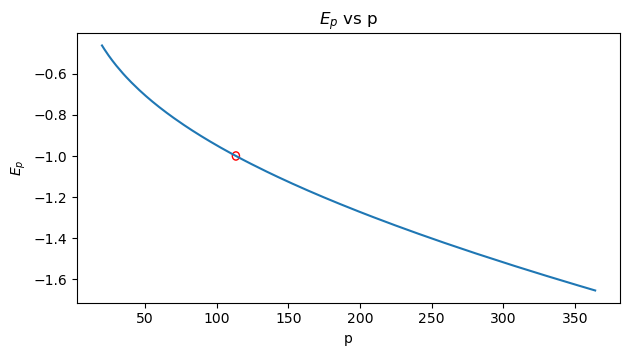

In [9]:
plot_point_elasticities(pnt_df)

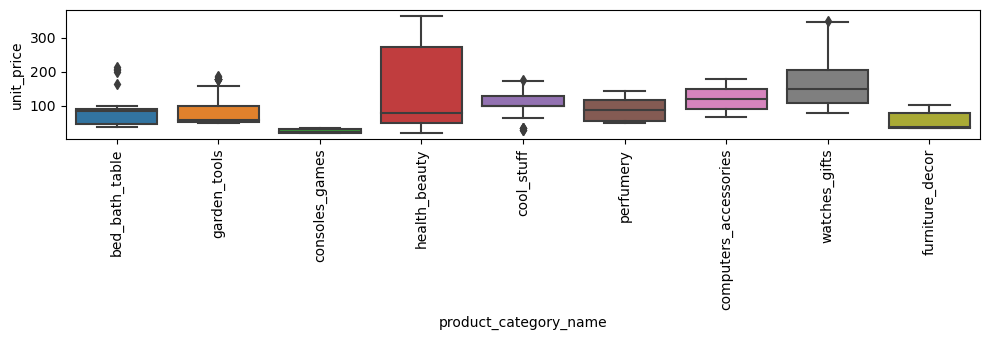

In [52]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 3.5))

sns.boxplot(df, x='product_category_name', y='unit_price', ax=ax)
ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

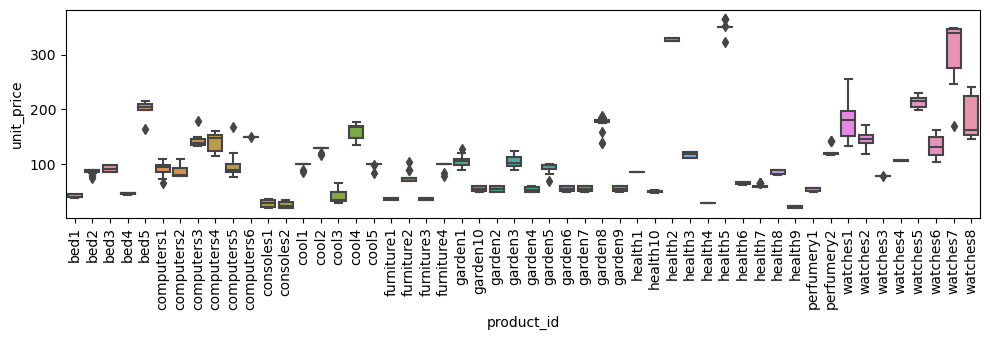

In [63]:
fig, ax = plt.subplots(figsize=(10, 3.5))

sns.boxplot(df, x='product_id', y='unit_price', order=sorted(df['product_id'].unique()))
ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

In [77]:
def get_elasticity(df):
    X, y = get_Xy(df)
    m = get_model(X, y)
    return m.coef_[0]

pd.Series({cat: get_elasticity(df[df['product_category_name']==cat]) 
           for cat in df['product_category_name'].unique()}) \
    .sort_values() \
    .to_frame() \
    .rename(columns={0: 'dq/dp'})

,dq/dp
consoles_games,-3.142899
perfumery,-1.369517
watches_gifts,-1.215955
furniture_decor,-1.047662
garden_tools,-1.030628
cool_stuff,-0.445491
bed_bath_table,-0.333410
health_beauty,-0.100198
computers_accessories,0.045713


In [78]:
pd.Series({prd: get_elasticity(df[df['product_id']==prd]) 
           for prd in df['product_id'].unique()}) \
    .sort_values() \
    .to_frame() \
    .rename(columns={0: 'dq/dp'})

,dq/dp
computers6,-805.349642
furniture2,-11.845124
bed5,-6.958227
health10,-5.413606
bed4,-4.454368
garden3,-4.182236
perfumery2,-4.146717
cool3,-4.058066
computers5,-3.716530
consoles2,-3.431087
